In [ ]:
%matplotlib

In [ ]:
%matplotlib inline

In [ ]:
pd.set_option('display.max_rows',    100)      # DataFrame 데이터 확인 시 최대 표시 행 수
pd.set_option('display.max_columns', 100)      # DataFrame 데이터 확인 시 최대 표시 열 수

## 라이브러리 import 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import tensorflow as tf
from tensorflow import keras

## 데이터 불러오기

In [2]:
Fold       = 5
Fs         = 12800  # Sampling Frequency
NoOfSensor = 1


# k-fold 학습/검증 데이터
for i in range(Fold):
    
    path1 = './K_FoldData/CNN_Training_Fold%d'%(i+1)
    path2 = './K_FoldData/CNN_Validation_Fold%d'%(i+1)
    c1 = 'temp_Training_Fold%d   = np.array(pd.read_csv(path1, sep=",", header=None))'%(i+1)
    c2 = 'temp_Validation_Fold%d = np.array(pd.read_csv(path2, sep=",", header=None))'%(i+1)
    exec(c1)
    exec(c2)

# K-fold 학습/검증 레이블
TrainingFold_Label   = np.array(pd.read_csv('./K_FoldData/TrainingFold_Label_forANN'  , sep=",", header=None))
ValidationFold_Label = np.array(pd.read_csv('./K_FoldData/ValidationFold_Label_forANN', sep=",", header=None))
    
    
# 전체 학습용 데이터
temp_Training_All  = np.array(pd.read_csv('./K_FoldData/CNN_Training_All', sep = ",", header = None))
Training_All_Label = np.array(pd.read_csv('./K_FoldData/Training_All_Label_forANN', sep = ",", header = None))

print(temp_Training_Fold1.shape)
print(temp_Validation_Fold1.shape)
print(TrainingFold_Label.shape)
print(ValidationFold_Label.shape)
print(temp_Training_All.shape)

(256, 2774)
(64, 2774)
(256, 2)
(64, 2)
(320, 2774)


## STFT 실행 (Spectrogram 생성)

In [3]:
# STFT test

f,t,Sxx = signal.spectrogram(temp_Training_All, Fs, nperseg=78)
print("STFT Result            :", Sxx.shape)

# Data Reshape for CNN
Training_All = Sxx.reshape(Sxx.shape[0], Sxx.shape[1], Sxx.shape[2], NoOfSensor)
print("Reshape_for_CNN Result :", Training_All.shape)

STFT Result            : (320, 40, 40)
Reshape_for_CNN Result : (320, 40, 40, 1)


In [4]:
for i in range(Fold):
    s1 = 'f,t,Sxx1 = signal.spectrogram(temp_Training_Fold%d, Fs, nperseg=78)'   %(i+1)
    s2 = 'f,t,Sxx2 = signal.spectrogram(temp_Validation_Fold%d, Fs, nperseg=78)' %(i+1)
    exec(s1)
    exec(s2)
    
    s3 = 'Training_Fold%d   = Sxx1.reshape(Sxx1.shape[0], Sxx1.shape[1], Sxx1.shape[2], NoOfSensor)' %(i+1)
    s4 = 'Validation_Fold%d = Sxx2.reshape(Sxx2.shape[0], Sxx2.shape[1], Sxx2.shape[2], NoOfSensor)' %(i+1)
    exec(s3)
    exec(s4)


print(f.shape, t.shape, Training_Fold1.shape, Validation_Fold1.shape)

(40,) (40,) (256, 40, 40, 1) (64, 40, 40, 1)


## CNN(Convolution Neural Network) hyperparameter 설정

In [5]:
learningRate  = 0.0001
iteration     = 1000

## Keras 기반 CNN 구조(Architecture) 설계

In [6]:
def CNN_model(input_data):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(4, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu',
                                  input_shape=(input_data.shape[1],input_data.shape[2],input_data.shape[3]))) # Convolution layer 1
    model.add(keras.layers.MaxPooling2D(pool_size = (2, 2), strides=(2, 2)))                                  # Pooling layer 1
    model.add(keras.layers.Conv2D(8, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu'))   # Convolution layer 2
    model.add(keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)))                                 # Pooling layer 2
    model.add(keras.layers.Conv2D(16, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu'))  # Convolution layer 3
    model.add(keras.layers.GlobalAveragePooling2D())                                                          # Global Average Pooling
    model.add(keras.layers.Dense(units = 2, activation='softmax'))                                            # Output Layer

    
    model.compile(optimizer= keras.optimizers.Adam(learning_rate = learningRate),
                  loss=keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
    return model

## CNN(Convolution Neural Network) 학습 및 평가 방법

In [7]:
tf.random.set_seed(777)

Data      = Training_Fold1
Data_Val  = Validation_Fold1
Label     = TrainingFold_Label
Label_Val = ValidationFold_Label

model = CNN_model(Data)

hist = model.fit(Data, Label, epochs=iteration, verbose = 0)
Loss, Accuracy = model.evaluate(Data_Val,  Label_Val, verbose=0)

Accuracy

0.953125

## CNN(Convolution Neural Network) 학습 및 검증

In [8]:
Label        = TrainingFold_Label
Label_Val    = ValidationFold_Label
Accuracy_sum = 0

print('[Reslut of K-fold Cross Validation] \n')

for i in range(Fold):
    tf.random.set_seed(777)
    
    s1= 'Data = Training_Fold%d'%(i+1)
    s2= 'Data_Val = Validation_Fold%d'%(i+1)
    exec(s1)
    exec(s2)
    
    model = CNN_model(Data)
    
# train my model
    hist = model.fit(Data, Label, epochs=iteration, verbose = 0)
    Loss, Accuracy = model.evaluate(Data_Val,  Label_Val, verbose=0)
    Accuracy_sum = Accuracy_sum + Accuracy
    print('Fold {}: {:.2f}%'.format((i+1), Accuracy*100))

print('* Average accuracy : {:.2f}%'.format((Accuracy_sum/Fold)*100))

[Reslut of K-fold Cross Validation] 

Fold 1: 95.31%
Fold 2: 96.88%
Fold 3: 100.00%
Fold 4: 98.44%
Fold 5: 98.44%
* Average accuracy : 97.81%


## 전체 학습 데이터로 NN 학습 및 모델 저장

In [9]:
PrintAccPerEpochs = 200

class AccuracyPerEpoch(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keras.callbacks.Callback()
        if epoch%PrintAccPerEpochs == 0:
            print("{} Epochs Accuracy : {:.2f}% ".format(epoch, logs["accuracy"]*100))

In [10]:
tf.random.set_seed(777)    

Data  = Training_All
Label = Training_All_Label

model = CNN_model(Training_All)
hist = model.fit(Data, Label, epochs=iteration, verbose = 0, callbacks = [AccuracyPerEpoch()])

print('Final Accuracy      : {:.2f}%'.format(hist.history['accuracy'][-1]*100))

0 Epochs Accuracy : 50.00% 
200 Epochs Accuracy : 61.25% 
400 Epochs Accuracy : 63.13% 
600 Epochs Accuracy : 95.63% 
800 Epochs Accuracy : 97.50% 
Final Accuracy      : 98.12%


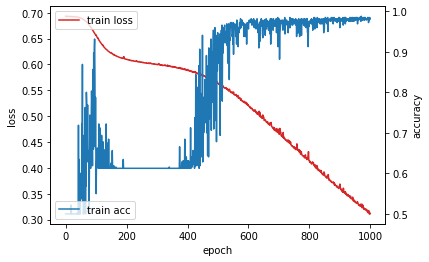

In [11]:
# 학습 과정 확인

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss', c = 'tab:red')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc', c = 'tab:blue')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower left')

plt.show()

In [12]:
# 모델 저장
model.save("./MLmodels/CNN_model.h5")

## NN model 불러와서 진단

In [13]:
# 모델 불러오기
LoadedModel = keras.models.load_model("./MLmodels/CNN_model.h5")

In [14]:
temp_Test_Data         = np.array(pd.read_csv('./K_FoldData/CNN_Test_Data' , sep=",", header=None))
Test_Label_forANN = np.array(pd.read_csv('./K_FoldData/Test_Label_forANN', sep=",", header=None))

In [15]:
f,t,Test_Data = signal.spectrogram(temp_Test_Data, Fs, nperseg = 78)
print("STFT Result            :", Test_Data.shape)

# Data Reshape for CNN
Test_Data = Test_Data.reshape(Test_Data.shape[0], Test_Data.shape[1], Test_Data.shape[2], NoOfSensor)
print("Reshape_for_CNN Result :", Test_Data.shape)

STFT Result            : (40, 40, 40)
Reshape_for_CNN Result : (40, 40, 40, 1)


In [16]:
Loss, Accuracy = LoadedModel.evaluate(Test_Data,  Test_Label_forANN, verbose=0)
print('[Performance of CNN model] \n')
print('Accuracy : {:.2f}%'.format(Accuracy*100))

[Performance of CNN model] 

Accuracy : 97.50%


In [17]:
# 예측값 확인
Predict_y = LoadedModel.predict(Test_Data)
pd.DataFrame(Predict_y)

,0,1
0,0.736479,0.263521
1,0.787540,0.212460
2,0.754004,0.245996
3,0.868809,0.131191
4,0.541741,0.458259
5,0.785535,0.214465
6,0.824092,0.175908
7,0.674592,0.325408
8,1.000000,0.000000
9,0.737169,0.262831
